In [1]:
from collections import deque, namedtuple
from random import sample
import numpy as np
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt 

In [2]:
env = gym.make('LunarLander-v2')

C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
num_episodes = 3
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        #render the env
        env.render()
    print("The episode total rewards is ", total_rewards)

env.close()

The episode total rewards is  -135.17469718325276
The episode total rewards is  -116.7741200625006
The episode total rewards is  -265.583606382973


In [51]:
state = env.reset()
state

array([-5.8755872e-04,  1.4036485e+00, -5.9532933e-02, -3.2317889e-01,
        6.8766251e-04,  1.3485086e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [4]:
class Deep_Q_Network(nn.Module):
    def __init__(self,num_states,num_actions):
        super(Deep_Q_Network,self).__init__()
        self.fc1 = nn.Linear(num_states,200)
        self.fc2 = nn.Linear(200,300)
        self.fc3 = nn.Linear(300,num_actions)
    
    def forward(self,states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [85]:
model = Deep_Q_Network(8,4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
states = env.reset()
states = torch.from_numpy(states[np.newaxis,:]).to(device)
model(states).max()

tensor(0.0241, grad_fn=<MaxBackward1>)

In [5]:
class MemoryReplay:
    def __init__(self, max_size):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.Dones = []
        self.max_size = max_size
        self.idx = 0
        self.size = 0

    def append(self, state,action, reward,next_state,Done):
        #first in, first out 
        if self.idx <= self.max_size:
            self.states.append(state)
            self.actions.append(action)
            self.rewards.append(reward)
            self.next_states.append(next_state)
            self.Dones.append(Done)
        else:
            #overwrite older values 
            self.states[self.idx] = state
            self.actions[self.idx]= action
            self.rewards[self.idx] = reward
            self.next_states[self.idx] =next_state
            self.Dones[self.idx] = Done
        self.size = min(self.size + 1, self.max_size)
        self.idx = (self.idx + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        states = np.array(self.states)[indices]
        actions =  np.array(self.actions)[indices]
        rewards = np.array(self.rewards)[indices]
        next_states = np.array(self.next_states)[indices]
        Dones = np.array(self.Dones)[indices]
        
        return states,actions, rewards, next_states, Dones
    def __len__(self):
        return self.size

## test Memory Replay 

In [19]:
m = MemoryReplay(10000)

num_episodes = 150
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        m.append(state,action,reward,next_state,Done)
        state = next_state
    print("The episode total rewards is ", total_rewards)

len(m)

The episode total rewards is  -142.61625549606092
The episode total rewards is  -207.46039232659484
The episode total rewards is  -173.01854310039295
The episode total rewards is  -110.59911912712009
The episode total rewards is  -162.81149742134363
The episode total rewards is  -106.30851237925413
The episode total rewards is  -107.41855043556387
The episode total rewards is  -69.35876394794022
The episode total rewards is  -94.56840862276391
The episode total rewards is  -88.46855301379716
The episode total rewards is  -96.54531108500206
The episode total rewards is  -148.06044444110745
The episode total rewards is  -202.45618483173666
The episode total rewards is  -84.38938170435502
The episode total rewards is  -172.0788752017715
The episode total rewards is  -428.9699693795071
The episode total rewards is  -135.22757194064695
The episode total rewards is  -146.87689810699914
The episode total rewards is  -226.23405800145838
The episode total rewards is  -334.41505709257353
The epi

10000

In [21]:
%timeit m.sample(64)

8.65 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
class DQL_Agent:
    def __init__(self,env,memory_max_size =100_000,dicount= 0.99,lr_optim=1e-3):
        self.env = env
        self.num_states = env.observation_space.shape[0]
        self.num_action = env.action_space.n
        self.dicount = dicount
        
        self.eps = 1.0
        self.decay_rate_eps = 0.993
        self.min_eps = 0.05
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.reply_memory = MemoryReplay(memory_max_size)
        self.Q_action = Deep_Q_Network(self.num_states,self.num_action).to(self.device)
        self.Q_target = Deep_Q_Network(self.num_states,self.num_action).to(self.device)
        self.Q_target.eval() #will turn off any dropout or batch norm layer 
        #make sure both network has identical weights 
        self.update_target_weights()
        
        self.loss_fucntion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.Q_action.parameters(),lr=lr_optim)
        
        
    def update_target_weights(self):
        self.Q_target.load_state_dict(self.Q_action.state_dict())
    
    def eps_greedy(self,states):
        if np.random.rand()<self.eps:
            return self.env.action_space.sample()
        else:
            #act greedy
            
            #make sure the state are tensor in order to feed it to the network
            if not torch.is_tensor(states):
                states = torch.from_numpy(states[np.newaxis,:]).float().to(self.device)
            with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
                action = self.Q_action(states)
            max_action = torch.argmax(action).item()
            return max_action
    
    def decay_eps(self):
        self.eps = np.maximum(self.eps*self.decay_rate_eps,self.min_eps)
    
    def to_tensor(self,states, actions, rewards,next_states,Dones):
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        Dones = torch.from_numpy(Dones).to(self.device)
        return states, actions, rewards, next_states, Dones
    def learnFromExperience(self,miniBatchSize): #hallucinations
        if miniBatchSize <2:
            raise ValueError("batch size must greater than 1")
        #make sure we have enough experiences 
        if len(self.reply_memory) < miniBatchSize:
            return #not enough experience, sounds familiar right?
        #else sample and learn
        states, actions, rewards, next_states, Dones = self.reply_memory.sample(miniBatchSize)
        #convert the result to tensor for model input 
        states, actions, rewards, next_states, Dones = self.to_tensor(states, actions, rewards, next_states, Dones)
        #calculate the current Q estimation 
        Q_estimate = self.Q_action(states)
        #obtain the q value for the actioned used in the experiences 
        Q_estimate_a = Q_estimate.gather(1, actions.view(-1, 1)).squeeze(1)
        
        #calculate the target value using --> rewards + discount* argmax_a Q(next_state, target_network_weight)
        #the max gives both the max values and the indices 
        Q_target = self.Q_target(next_states).max(dim=1).values
        #note that one the state is terminal, we only count the reward, therefore, we need to check if the state is Dones
        #if Done is true, we should not calculate Q for the next states 
        Q_target[Dones] = 0.0 
        #final target calculation
        Q_target = rewards + self.dicount*Q_target
        
        #make sure the grad is zero 
        self.optimizer.zero_grad()

        #calculate the loss 
        loss=self.loss_fucntion(Q_target,Q_estimate_a)
        #calcualte the gradient dL/dw
        loss.backward()
        #optimize using gradient decent
        self.optimizer.step()
        
    def get_max_action(self,states):
        self.Q_action.eval()
        #make sure the state are tensor in order to feed it to the network
        if not torch.is_tensor(states):
            states = torch.from_numpy(states[np.newaxis,:]).to(self.device)
        with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
            action = self.Q_target(states)
        max_action = torch.argmax(action).item()
        return max_action
        
        
            
        

In [25]:
class Training_agent:
    #Agent and environment interaction
    def __init__(self, env,memory_max_size =10_000,dicount= 0.99,lr_optim=1e-3,update_freq =1000):
        self.agent = DQL_Agent(env,memory_max_size ,dicount ,lr_optim)
        self.update_freq = update_freq
        self.steps = 0 
    
    def train_agent(self, num_episodes,batch_size):
        self.rewards = np.zeros(num_episodes)
        self.moving_average = []
        for i in range(num_episodes):
            state = self.agent.env.reset()
            Done = False
            total_rewards = 0
            while not Done: 
                #take an action using the greedy policy
                action = self.agent.eps_greedy(state)
                #implement the action 
                next_state, reward, Done, info = self.agent.env.step(action)
                #save the experience in the memory of the agent 
                self.agent.reply_memory.append(state,action,reward,next_state,Done)
                #sum the rewards
                total_rewards += reward
                
                #learn from experience (if there is enough)
                self.agent.learnFromExperience(batch_size)
                #update the tarqet network per the desired frequency 
                self.steps +=1 
                if (self.steps % self.update_freq) == 0:
                    self.agent.update_target_weights()
                state = next_state
            #append the rewards
            self.rewards[i] = total_rewards
            self.moving_average.append(np.mean(self.rewards[-100:]))
            #update the eps 
            self.agent.decay_eps()
            if i %10 == 0:
                print("The episode {} total rewards is {}".format(i+1, total_rewards))
                print(len(self.agent.reply_memory))
    def test_agent(self,env,render=False):
        state = env.reset()
        Done = False 
        total_rewards = 0
        
        while not Done: 
            action = self.agent.get_max_action(state)
            next_state, reward,Done, info = env.step(action)
            total_rewards += reward
            if render:
                env.render()
            state = next_state
        print("The episode total rewards is ", total_rewards)
        env.close()
        
        

In [26]:
env = gym.make('LunarLander-v2')
training_agent = Training_agent(env)
training_agent.train_agent(100,32)

C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 1 total rewards is -243.15536488611585
91
The episode 11 total rewards is -402.8978131612824
1053
The episode 21 total rewards is -38.8960014514666
2065
The episode 31 total rewards is -108.21886655151127
3044
The episode 41 total rewards is -68.04877959068988
4150
The episode 51 total rewards is -358.3841423813191
5356
The episode 61 total rewards is -106.64991035459285
6607
The episode 71 total rewards is -118.2626156574455
8715
The episode 81 total rewards is -45.93909662416678
9969
The episode 91 total rewards is -90.45288253633441
10000


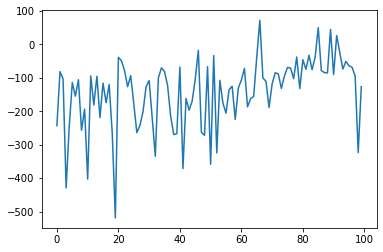

In [27]:
plt.plot(training_agent.rewards)

In [282]:
print(training_agent.agent.eps)
training_agent.test_agent(render=True)


0.05
The episode total rewards is  -720.0402136060908
